In [16]:
import sys
print(sys.version)
%load_ext autoreload
%autoreload 2

3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np

In [18]:
mpl.rcParams['pdf.fonttype'] = 42

# Plotting from primer analysis

Before plotting you will need to load the utility functions from below.

## Floral scent

In [19]:
DATA_SOURCES = ["scent", "fv"]
SPECIES = ["prim", "gent", "rhod"]

### _Primula_

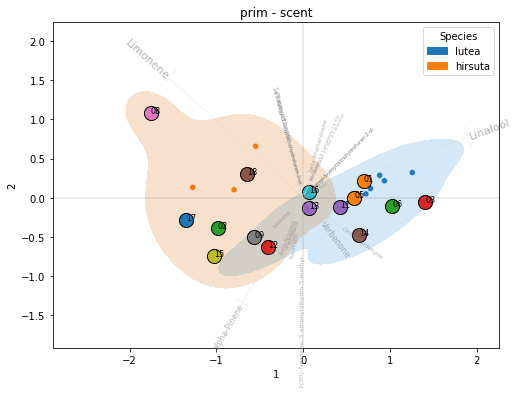

In [62]:
plot_nmds(SPECIES[0], DATA_SOURCES[0], kde=True)

### _Rhododendron_

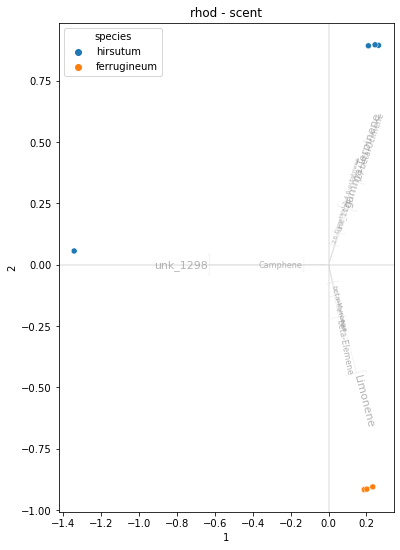

In [22]:
plot_nmds(SPECIES[2], DATA_SOURCES[0])

## Flower visitors

### _Primula_

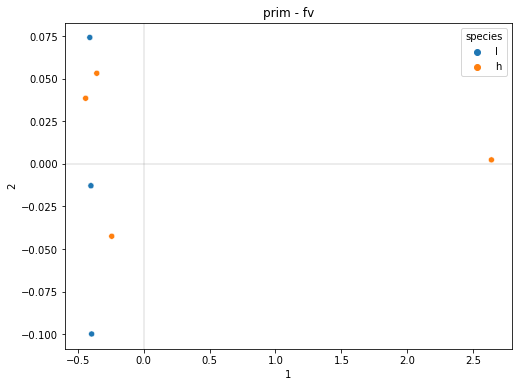

In [310]:
plot_nmds(SPECIES[0], DATA_SOURCES[1])

### _Gentiana_

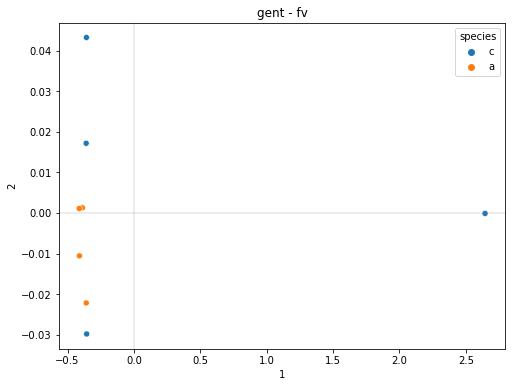

In [311]:
plot_nmds(SPECIES[1], DATA_SOURCES[1])

### _Rhododendron_

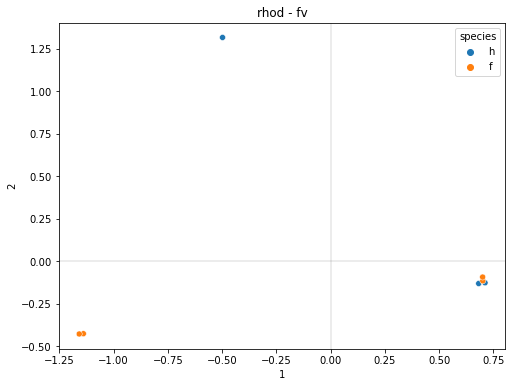

In [312]:
plot_nmds(SPECIES[2], DATA_SOURCES[1])

# Utilities

In [21]:
def plot_nmds(species, data_source, kde=False):
    """
    Plot an nmds for given species and type of data source.
    """
    # store directory name
    files_core = f"../data/primer_eval/csv/{data_source}_{species}"
    
    df, df_eigen = import_dataframes(files_core)
    
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1)
    ax.axvline(c="grey", alpha=.2)
    ax.axhline(c="grey", alpha=.2)

    # one file has different headers
    hue = "species" if (data_source != "scent" or species != "prim") else "Species"
    # plot the data
    sns.scatterplot(data=df, x='1', y='2', hue=hue, ax=ax)
    if kde:
        sns.kdeplot(data=df[~df[hue].str.contains("x")],
                    x='1',
                    y='2',
                    hue=hue,
                    ax=ax,
                    fill=True,
                    levels=2,
                    thresh=.1,
                    alpha=.2)
    ax.set_title(f"{species} - {data_source}")
    
    # make special adjustments
    if data_source == "scent":
        # add concentrations
        review_names(df_eigen, species)
        df_eigen = add_concentration_values(files_core, df_eigen)
        # use only longest vectors (here top 15%)
        df_eigen = filter_top_eigen(df_eigen)
        # plot evs
        ax = plot_eigenvectors(df_eigen, ax)
        # annotate numbers of portjoch specimen
        if species == "prim":
            ax = annotate_hybrid_population(df, ax)
    # store as pdf
    figure_name = f"{files_core.replace('data/primer_eval/csv/', 'figs/')}_nmds.pdf"
    save_figures_as_pdf(fig, figure_name)
    
    return 

In [2]:
def import_dataframes(files_core):
    """
    Import the coordinates and eigenvectors as dataframes.
    """
    df = pd.read_csv(f"{files_core}_coord.csv", index_col=0)
    df_eigen = pd.read_csv(f"{files_core}_eigen.csv", index_col=0).T
    
    return df, df_eigen

In [3]:
def save_figures_as_pdf(figure, file_name):
    import matplotlib.backends.backend_pdf

    pdf = matplotlib.backends.backend_pdf.PdfPages(file_name)
    pdf.savefig(figure, bbox_inches='tight')
    pdf.close()
    return

In [4]:
def annotate_hybrid_population(df, ax):
    """
    Add labels of individuals of the Portjoch (hybrid) population.
    """
    distance = .01
    for _, row in df[df["Population"] == "Por"].iterrows():
        dp = (row[0]+distance, row[1]+distance)
        ax.scatter(dp[0], dp[1], marker="o", edgecolor="black", s=200)
        ax.annotate(xy=dp,
                    text=row.name.split("_")[1],
                    size=8,
                    c="black"
        )
    return ax

In [5]:
def plot_eigenvectors(df_eigen, ax):
    """
    Add eigenvectors of the dimensions to given plot.
    Labels will be rotated and adjusted to concentrations.
    """
    # scale the arrows
    xax = min([abs(x) for x in ax.get_xlim()])
    yax = min([abs(x) for x in ax.get_ylim()])
    min_ax = min([xax, yax])
    max_comp = max(list(df_eigen.iloc[:, 0])+list(df_eigen.iloc[:, 1]))
    stretch_factor = min_ax / (1.*max_comp)

    # scale the font size by concentration
    mean_conc = df_eigen.iloc[:, 2]
    concis = np.log(mean_conc**4) 
    new_concis = concis - min(concis) - np.log2(.9)
    font_sizes = np.ceil(new_concis/2) + 4

    # adjust the coordinates
    x_coords = [x * stretch_factor for x in df_eigen.iloc[:, 0]]
    y_coords = [y * stretch_factor for y in df_eigen.iloc[:, 1]]

    # plot the arrows
    for a, b, compi, fs in zip(x_coords, y_coords, df_eigen.index, font_sizes):
        ax.annotate(xy=(0, 0),
                    xytext=(a, b),
                    text='',
                    size=int(fs),
                    arrowprops={'arrowstyle': ']-',
                                'alpha': .5,
                                'lw': .5,
                                'color': 'lightgrey'})
    
    # annotate rotated text
    for a, b, compi, fs in zip(x_coords, y_coords, df_eigen.index, font_sizes):
        hyp = np.linalg.norm([a, b])
        rotation = np.arccos(abs(a) / hyp) / np.pi * 180
        if np.isnan(rotation): rotation = .0
        va = 'center'
        if a <= 0:
            ha = 'right'
            if b >= 0:
                rotation = 360 - rotation
        else:
            ha = 'left'
            if b <= 0:
                rotation = 360 - rotation

        tr_rotation = plt.gca().transData.transform_angles(np.array((rotation,
                                                                     )),
                                                           np.array((a, b)).reshape((1, 2)))[0]
        ax.annotate(xy=(0, 0),
                    xytext=(a, b),
                    text=compi,
                    ha=ha,
                    va=va,
                    rotation=tr_rotation,
                    rotation_mode='anchor',
                    size=int(fs+1),
                    c='grey',
                    alpha=.6)
    return ax

In [6]:
def review_names(df_eigen, spec):
    """
    As some chemical compound names were changed somewhen within
    the analysis, a mapping dictionary needs to be provided.
    """
    df_names = pd.read_csv(f"../data/primer_eval/new_compound_names_{spec}.csv", header=None)
    names_dict = {row[1]: row[0] for _, row in df_names.iterrows()}
    df_eigen.index = [names_dict[x] for x in df_eigen.index]
    return df_eigen

In [7]:
def add_concentration_values(files_core, df_eigen):
    """
    Import concentration data and add to dataframe.
    """
    df_sum = pd.read_csv(f"{files_core}_sum.csv", header=1)
    compounds = [
        row["compound"] if "unknown" not in row["compound"] else
        f"unk_{row['retention_index']}" for 
        _, row in df_sum.iterrows()]
    df_conc = pd.DataFrame(
        df_sum.loc[:, ["mean", "mean.1"]].max(axis=1), columns=["concentration"])
    df_conc.index = compounds
    
    df_eigen = df_eigen.join(df_conc)
    df_eigen.dropna(inplace=True)
    
    return df_eigen

In [8]:
def filter_top_eigen(df_eigen):
    """
    Subset eigenvectors by length of vectors. Use only top TOP_PROPORTION of all.
    """
    TOP_PROPORTION = .15
    vector_lengths = df_eigen.iloc[:, [0,1]].apply(np.linalg.norm, axis=1)
    top_quantile = np.quantile(vector_lengths, 1-TOP_PROPORTION)
    top_quanter = vector_lengths.index[vector_lengths >= top_quantile]
    return df_eigen.loc[top_quanter, :]

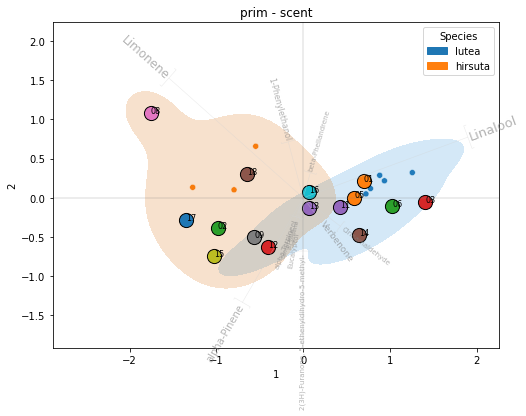

In [74]:
plot_nmds(SPECIES[0], DATA_SOURCES[0], kde=True)